WRITE A DESCRIPTION

In [76]:
! pip install simpy
import simpy
! pip install numpy
import numpy as np
! pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random

In [77]:
class Scheduler:

    def __init__(self, environment, unprocessed_tasks, type):

        self.environment = environment
        self.unprocessed_tasks = unprocessed_tasks
        self.type = type
        self.processed_tasks = []
        self.task_id_counter = 0
        self.currently_processing_task = None

        if type == "RANDOM":
            self.environment.process(self.process_randomly(self.environment))

        elif type == "FIFO":
            self.environment.process(self.process_fifo(self.environment))
        
        elif type == "LIFO":
            self.environment.process(self.process_lifo(self.environment))
        
        elif type == "EDF":
            self.environment.process(self.process_edf(self.environment))

        else:
            print("incorrect scheduling type... choose from: RANDOM, FIFO, LIFO or EDF")

    def process_randomly(self, environment):     #these while loops keep going after the simulation has finished, for some reason
        while True:
            
            if len(self.unprocessed_tasks) > 0:
                next_task = random.choice(self.unprocessed_tasks)
                yield environment.process(next_task.process())

            yield environment.timeout(1)

    def process_fifo(self, environment):
         while True:
            if len(self.unprocessed_tasks) > 0:
                 next_task = self.unprocessed_tasks[0]
                 yield environment.process(next_task.process())
            yield environment.timeout(1)

    def process_lifo(self, environment):
        while True:

            if len(self.unprocessed_tasks) > 0:
                next_task = self.unprocessed_tasks[-1]
                yield environment.process(next_task.process())

            yield environment.timeout(1) 

    def process_edf(self, environment):

        current_task_process = None
        highest_priority_task = None
        

        while True:
            
            if len(self.unprocessed_tasks) > 0:

                if(self.currently_processing_task == None):
                    self.currently_processing_task = min(self.unprocessed_tasks, key = lambda x: x.priority)
                    current_task_process = environment.process(self.currently_processing_task.process()) #yield?
                    continue

                highest_priority_task = min(self.unprocessed_tasks, key = lambda x: x.priority)

                if(self.currently_processing_task != highest_priority_task):
                    if self.currently_processing_task.priority > highest_priority_task.priority:
                        print(f"Interrupting Task {self.currently_processing_task.id} for Task {highest_priority_task.id} at {environment.now}")
                        interrupt_cause = simpy.Interrupt(current_task_process)
                        interrupt_cause.usage_since = environment.now
                        current_task_process.interrupt(interrupt_cause)
                        self.currently_processing_task = highest_priority_task
                        current_task_process = environment.process(self.currently_processing_task.process())

            yield environment.timeout(1)
            

  #  def process_oracle():


In [78]:
class Task:

    def __init__(self, id, priority, duration, vehicle, environment):

        self.id = id
        self.priority = priority
        self.duration = duration
        self.vehicle = vehicle
        self.environment = environment
        self.time_spent_processing = 0
        print(f'Vehicle {self.vehicle.id} generated a new Task at {self.environment.now} - new Task id:{self.id}, priority: {self.priority} and duration: {self.duration}')

    def process(self):
        try:
            start = self.environment.now
            print(f'Task {self.id} started processing at {self.environment.now}')

            #try to timeout for the time needed to complete the task
            yield self.environment.timeout(self.duration - self.time_spent_processing) 
            print(f'Task {self.id} completed at {self.environment.now}')
            self.vehicle.tasks_completed.append(self)   #or do this with scheduler processed tasks
            self.vehicle.scheduler.currently_processing_task = None
            if self in self.vehicle.scheduler.unprocessed_tasks:
                self.vehicle.scheduler.unprocessed_tasks.remove(self)

        except simpy.Interrupt as interrupt:
            usage = interrupt.cause.usage_since - start 
            #save the processing progress of the task
            self.time_spent_processing += usage
            print(f'Task {self.id} got preempted at {self.environment.now} after {usage} time entities')

In [79]:
class Vehicle:

    def __init__(self, id, environment, assigned_tasks, lambda_tasks, lambda_dwell_time, scheduler, generator):

        self.id = id
        self.environment = environment
        self.assigned_tasks = assigned_tasks
        self.tasks_completed = []
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time      #do sth with this
        self.scheduler = scheduler
        self.generator = generator

        self.inROI = True

        print(f'Vehicle {self.id} spawned in environment at time {self.environment.now}')

        #start lifecycle of every task that is created before simulation
        for task in assigned_tasks:     
            self.scheduler.task_id_counter += 1          
            self.scheduler.unprocessed_tasks.append(task)

        #start task generator
        self.environment.process(self.generateTasks())

    def scheduleDeparture(self, environment):
        yield environment.timeout(np.random.poisson(self.lambda_dwell_time))
        self.inROI = False

    def generateTasks(self):

        self.environment.process(self.scheduleDeparture(self.environment))

        while self.inROI:

            priority = random.randint(0, 5)
            duration = random.randint(1, 5)
            yield self.environment.timeout(np.random.poisson(self.lambda_tasks)) 
            
            #add task to vehicle
            new_task = Task(self.scheduler.task_id_counter, priority, duration, self, self.environment)
            self.assigned_tasks.append(new_task)
            self.scheduler.task_id_counter += 1

            #add task to scheduler queue
            self.scheduler.unprocessed_tasks.append(new_task) 
           
        self.generator.vehicles_present.remove(self)
        self.generator.vehicles_departed.append(self)

        print(f"vehicle {self.id} left the intersection and stopped generating tasks at {self.environment.now}")

In [80]:
class VehicleGenerator:

    def __init__(self, lambda_vehicles, lambda_tasks, lambda_dwell_time, environment, scheduler):
        
        self.lambda_vehicles = lambda_vehicles
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time
        self.environment = environment
        self.scheduler = scheduler

        self.vehicles = []
        self.vehicles_present = []
        self.vehicles_departed = []
        self.vehicle_count = 0

        self.environment.process(self.generateVehicles(self.environment))
    
    def vehicles_generated(self):
        return len(self.vehicles)
    
    def tasks_generated(self):
        counter = 0
        for vehicle in self.vehicles:
            counter += len(vehicle.assigned_tasks)
        return counter
    
    def tasks_completed(self):
        counter = 0
        for vehicle in self.vehicles:
            counter += len(vehicle.tasks_completed)
        return counter
    
    def mean_tasks_completed_per_vehicle(self):
        
        mean = 0
        deleted_counter = 0

        #remove vehicles which haven't generated tasks
        for v in self.vehicles:
            if len(v.assigned_tasks) == 0:
                self.vehicles.remove(v)
                deleted_counter += 1

        for v in self.vehicles:
            mean += len(v.tasks_completed)
            
        # sum (vehicle t completed / vehicle assigned tasks) / number of vehicles 
        mean = mean / (len(self.vehicles)-deleted_counter)
        return mean
    
    def time_spent_processing(self):

        result = []
        
        for v in self.vehicles:

            v_processing_time = 0
            
            incomplete_tasks = [t for t in v.assigned_tasks if t not in v.tasks_completed]
            
            #add duration from all completed tasks of a vehicle
            for t in v.tasks_completed:
                v_processing_time += t.duration
            #add processing duration from all incomplete tasks of a vehicle
            for t in incomplete_tasks:
                v_processing_time += t.time_spent_processing
            
            result.append(v_processing_time)    
                
        #should hold the time spent processing for each vehicle   
        return result 
    
    def scheduling_type(self):
        result = []
        for v in self.vehicles:
            result.append(v.scheduler.type)
        return result
    
    def dropped_tasks(self):
        result = 0

        for v in self.vehicles:
            incomplete_tasks = [t for t in v.assigned_tasks if t not in v.tasks_completed]
            
            for t in incomplete_tasks:
                #make sure incomplete task has processed 
                if t.time_spent_processing == 0:
                    incomplete_tasks.remove(t)
            result += len(incomplete_tasks)
            
        return result

        
    def generateVehicles(self, environment):

        while True:
             timeout = np.random.poisson(self.lambda_vehicles)
             yield environment.timeout(timeout)
             new_vehicle = Vehicle(self.vehicle_count, environment,[], self.lambda_tasks, self.lambda_dwell_time, self.scheduler, self)
             self.vehicle_count += 1 
             self.vehicles.append(new_vehicle)
             self.vehicles_present.append(new_vehicle)


In [100]:
scheduling_type = ['RANDOM', 'FIFO', 'LIFO', 'EDF']
simulation_data = None
processing_time = None
mean_processing_time = None

#run simulation once for each scheduling type
def run_sim(sim_seed, scheduling_type, poisson_vehicles, poisson_tasks, poisson_dwell_time, sim_end_time):

   #simulation data to be collected

   global simulation_data
   global processing_time
   global mean_processing_time

   total_vehicles_generated  = []
   total_tasks_generated = []
   total_tasks_completed = []
   total_tasks_completed_percentage = []
   avg_tasks_completed_per_vehicle = []
   tasks_begun_vs_dropped = []
   pt_scheduling_type = []
   total_processing_time_of_vehicle = []
   mean_processing_time_per_scheduler = []

   for type in scheduling_type:

      random.seed(sim_seed)
      np.random.seed(sim_seed)
        
      #run simulation
      intersection = simpy.Environment()
      scheduler = Scheduler(intersection, [], type)
      vehicle_generator = VehicleGenerator(poisson_vehicles, poisson_tasks, poisson_dwell_time, intersection, scheduler)
      intersection.run(until = sim_end_time)
      print(f"scheduler: {scheduler.type}")
      print(f"total vehicles spawned: {vehicle_generator.vehicles_generated()}")
      print(f"total tasks generated: {vehicle_generator.tasks_generated()}")

      #document results
      total_vehicles_generated.append(len(vehicle_generator.vehicles))
      total_tasks_generated.append(vehicle_generator.tasks_generated())
      total_tasks_completed.append(vehicle_generator.tasks_completed())
      total_tasks_completed_percentage.append(vehicle_generator.tasks_completed()/vehicle_generator.tasks_generated() * 100)
      avg_tasks_completed_per_vehicle.append(vehicle_generator.mean_tasks_completed_per_vehicle())
      tasks_begun_vs_dropped.append(vehicle_generator.dropped_tasks())
      pt_scheduling_type.append(vehicle_generator.scheduling_type())
      total_processing_time_of_vehicle.append(vehicle_generator.time_spent_processing())
      #processing_time.append(vehicle_generator.time_spent_processing())

   pt_scheduling_type = np.concatenate(pt_scheduling_type).ravel().tolist()
   total_processing_time_of_vehicle = np.concatenate(total_processing_time_of_vehicle).ravel().tolist()

   pt = pd.DataFrame({
      "scheduling type" : pt_scheduling_type,
      "total processing time of vehicle" : total_processing_time_of_vehicle,
   })

   processing_time = pt

   mean_processing_time = pt.groupby('scheduling type')['total processing time of vehicle'].agg(['mean', 'sum']).reset_index()
   mean_processing_time['mean'] = mean_processing_time['mean'].round(1)

   sim_data = pd.DataFrame({
      'scheduling type' : scheduling_type,
      'total vehicles generated: ' : total_vehicles_generated,
      'total tasks generated:' : total_tasks_generated,
      'total tasks completed' : total_tasks_completed,
      'total tasks completed percentage' : total_tasks_completed_percentage,
      'avg. tasks completed per vehicle' : avg_tasks_completed_per_vehicle,
      'tasks dropped percentage' : tasks_begun_vs_dropped,
   })

   simulation_data = sim_data




In [101]:
poisson_vehicles = 5          # expected time interval per vehicle spawn
poisson_tasks = 2.5           # expected time interval per task generation
poisson_dwell_time = 30       # expected time spent at intersection
end_time = 100
run_sim(42, scheduling_type, poisson_vehicles, poisson_tasks, poisson_dwell_time, end_time)

Vehicle 0 spawned in environment at time 5
Vehicle 0 generated a new Task at 8 - new Task id:0, priority: 5 and duration: 1
Task 0 started processing at 8
Vehicle 1 spawned in environment at time 9
Task 0 completed at 9
Vehicle 0 generated a new Task at 10 - new Task id:1, priority: 0 and duration: 3
Task 1 started processing at 10
Vehicle 1 generated a new Task at 11 - new Task id:2, priority: 1 and duration: 2
Vehicle 0 generated a new Task at 12 - new Task id:3, priority: 5 and duration: 1
Vehicle 2 spawned in environment at time 13
Task 1 completed at 13
Vehicle 0 generated a new Task at 14 - new Task id:4, priority: 0 and duration: 1
Task 4 started processing at 14
Vehicle 1 generated a new Task at 15 - new Task id:5, priority: 4 and duration: 4
Vehicle 0 generated a new Task at 15 - new Task id:6, priority: 1 and duration: 5
Task 4 completed at 15
Vehicle 3 spawned in environment at time 16
Vehicle 2 generated a new Task at 16 - new Task id:7, priority: 0 and duration: 2
Vehicle 

  scheduling type  total vehicles generated:   total tasks generated:  \
0          RANDOM                          22                     221   
1            FIFO                          22                     221   
2            LIFO                          22                     221   
3             EDF                          22                     221   

   total tasks completed  total tasks completed percentage  \
0                     26                         11.764706   
1                     22                          9.954751   
2                     24                         10.859729   
3                     29                         13.122172   

   avg. tasks completed per vehicle  tasks dropped percentage  
0                          1.181818                        91  
1                          1.000000                        92  
2                          1.090909                        93  
3                          1.318182                        91  
   

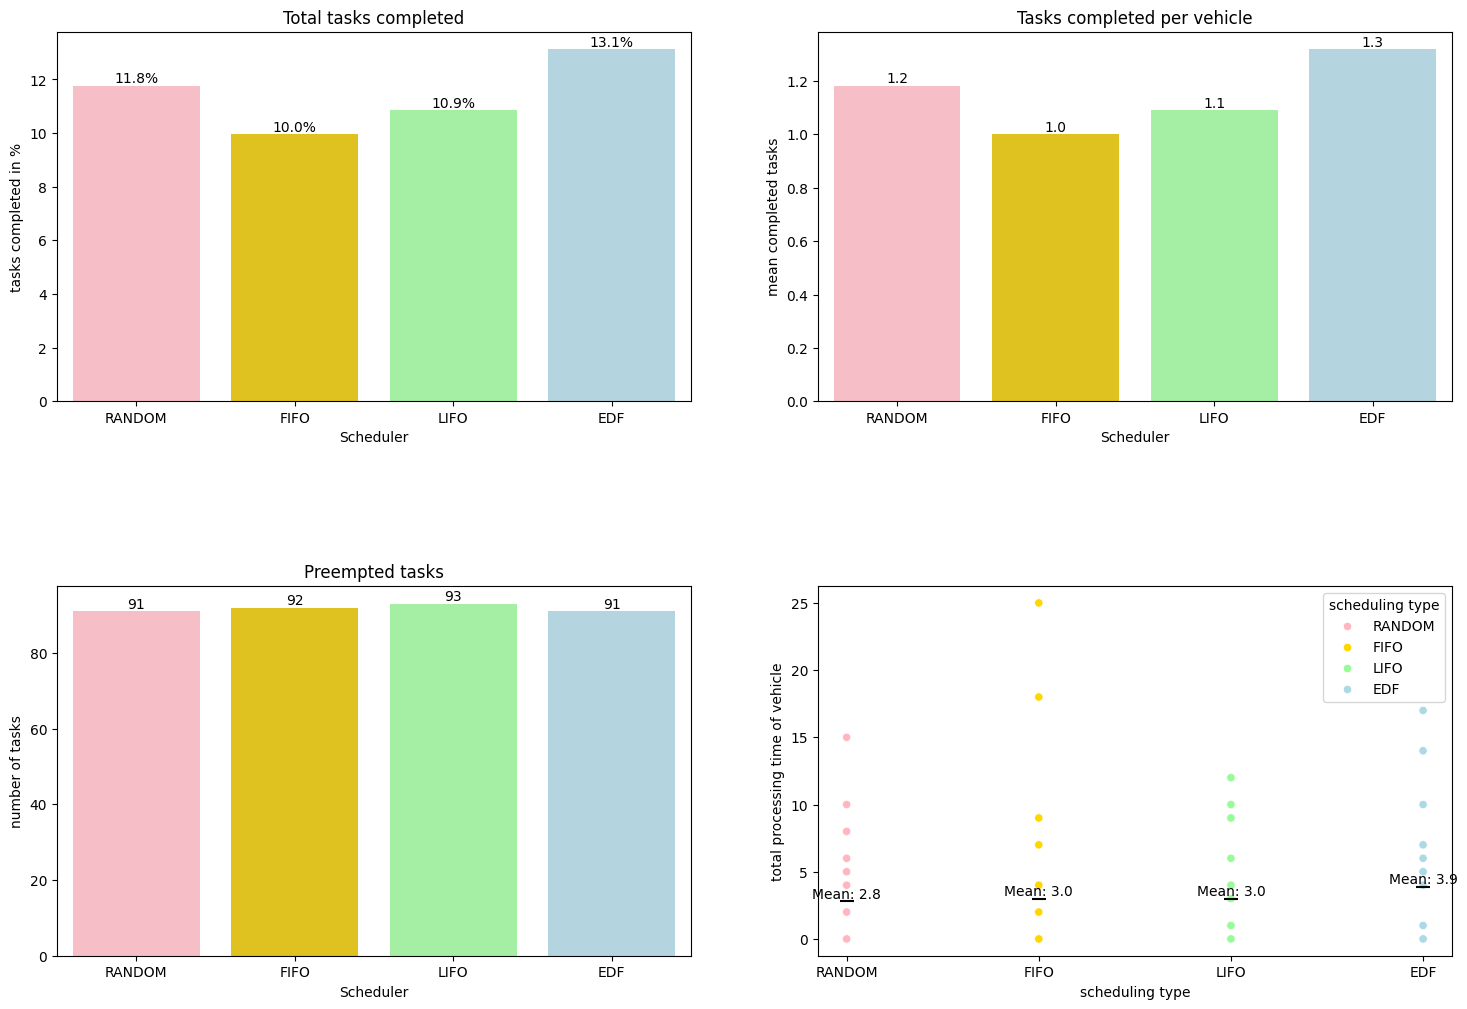

In [102]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)

# Define pastel colors
pastel_colors = ['#FFB6C1', '#FFD700', '#98FB98', '#ADD8E6']

# Plot 1
sns.barplot(x=scheduling_type, y=simulation_data['total tasks completed percentage'], ax=axes[0, 0], hue=scheduling_type, palette=pastel_colors)
axes[0, 0].set_title('Total tasks completed')
axes[0, 0].set_xlabel('Scheduler')
axes[0, 0].set_ylabel('tasks completed in %')

# Plot 2
sns.barplot(x=scheduling_type, y=simulation_data['avg. tasks completed per vehicle'], ax=axes[0, 1], hue=scheduling_type, palette=pastel_colors)
axes[0, 1].set_title('Tasks completed per vehicle')
axes[0, 1].set_xlabel('Scheduler')
axes[0, 1].set_ylabel('mean completed tasks')

# Plot 3
sns.barplot(x=scheduling_type, y=simulation_data['tasks dropped percentage'], ax=axes[1, 0], hue=scheduling_type, palette=pastel_colors)
axes[1, 0].set_title('Preempted tasks')
axes[1, 0].set_xlabel('Scheduler')
axes[1, 0].set_ylabel('number of tasks')

# plot 4
sns.scatterplot(data=processing_time, x='scheduling type', y='total processing time of vehicle', ax=axes[1, 1],hue = 'scheduling type', palette=pastel_colors)

#labeling the plots
for index, value in enumerate(simulation_data['total tasks completed percentage']):
    axes[0, 0].text(index, value, f"{round(value,1)}%", ha='center', va='bottom')

for index, value in enumerate(simulation_data['avg. tasks completed per vehicle']):
    axes[0, 1].text(index, value, str(round(value,1)), ha='center', va='bottom')

for index, value in enumerate(simulation_data['tasks dropped percentage']):
    axes[1, 0].text(index, value, str(value), ha='center', va='bottom')

    # Add mean as separate points
for index, row in mean_processing_time.iterrows():
    mean = row['mean']
    total = row['sum']
    axes[1, 1].scatter(row['scheduling type'], mean, color='black', marker='_', s=100)
    axes[1, 1].text(row['scheduling type'], mean, f'Mean: {mean}', ha='center', va='bottom')

print(simulation_data)
print(processing_time)
plt.show()